# Project #3
## Predicting Voting Results

In [1]:
import geopandas as gpd
import mapclassify
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.ensemble import RandomForestRegressor

In [2]:
gdf = gpd.read_file('./va_admin_bndry/VirginiaCounty_ClippedToShoreline.shx')
vdf = pd.read_csv('./data/voting_VA.csv')
cdf = pd.read_csv('./data/county_adjacencies.csv')


In [3]:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS']) 
df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')

In [4]:
for y in vdf['year'].unique():
    df20 = vdf.loc[ vdf['year']==y,:]

    Dvotes = df20.loc[(df20['party']=='DEMOCRAT'),:].groupby('county_fips')['candidatevotes'].sum()
    Dvotes = Dvotes.rename('dem_votes_' + str(y))
    df = df.merge(Dvotes,left_on='FIPS_left',right_on='county_fips')

    Rvotes = df20.loc[(df20['party']=='REPUBLICAN'),:].groupby('county_fips')['candidatevotes'].sum()
    Rvotes = Rvotes.rename('rep_votes_' + str(y))
    df = df.merge(Rvotes,left_on='FIPS_left',right_on='county_fips')

In [5]:
#cleans data by extracting votes by year for each county
def extract_df(index):
    row = df.iloc[index]
    years = []
    dem_votes = []
    rep_votes = []

    for column in df.columns:
        if column.startswith('dem_votes'):
            year = column.split('_')[-1]
            years.append(year)
            dem_votes.append(row[column])
            rep_votes.append(row['rep_votes_' + year])

    result_df = pd.DataFrame({'dem_votes': dem_votes, 'rep_votes': rep_votes})
    result_df['vote_diff'] = result_df['rep_votes']-result_df['dem_votes']
    return result_df


In [6]:

def ensemble(df):
    # Split data into training rows and testing rows:
    N = df.shape[0]
    df = df.sample(frac=1, random_state=100) # randomize the order in which data appears
    train_size = int(.8*N)
    df_train = df[0:train_size]
    N_train = df_train.shape[0]
    df_test = df[train_size:]
    N_test = df_test.shape[0]

    # Bootstrap:
    T = 300
    m_depth = 4
    Rsq = np.zeros(T) # preallocate the rsq measure
    y_test_hat = np.zeros([T,N_test]) # preallocate predictions on test set
    df_train.head()

    # Split data into train/test:
    X_train = df_train.drop(['vote_diff'],axis=1)
    y_train = df_train['vote_diff']
    X_test = df_test.drop(['vote_diff'],axis=1)
    y_test = df_test['vote_diff']
    
    for s in range(T):
        # Generate a bootstrap sample:
        df_s = df_train.sample(frac=1, replace=True)
        X_s = df_s.drop('vote_diff',axis=1)
        y_s = df_s['vote_diff']
        # Fit decision tree:
        cart = tree.DecisionTreeRegressor(max_depth=m_depth) # Create a classifier object
        cart = cart.fit(X_s, y_s) # Fit the classifier
        # Compute Rsq:
        y_hat = cart.predict(X_test)
        SSE = np.sum( (y_test-y_hat)**2 )
        TSS = np.sum( (y_test-y_s.mean())**2 )
        Rsq[s] = 1 - SSE/TSS
        # Make and Save Predictions:
        y_test_hat[s,:] = y_hat
    
    # Ensemble predictor:
    y_hat_ensemble = y_test_hat.mean(axis=0) # Average the columns to get the ensemble prediction
    SSE = np.sum( (y_test-y_hat_ensemble)**2 )
    TSS = np.sum( (y_test-y_train.mean())**2 )
    Rsq_ensemble = 1 - SSE/TSS

    return (Rsq_ensemble, y_hat_ensemble.mean())
    # print(Rsq_ensemble)

    # print(y_hat_ensemble.mean())


Takes the average of all the r-sqared values from each individual ensemble prediction from each county:

In [7]:
r_avg = 0
total = 0
for i in range(len(df)):
    r_avg += ensemble(extract_df(i))[0]
    total += 1

r_avg /= total
print(r_avg)

0.1818462801395967


## Extract results:

In [8]:
def ensemble_result(i):
    return ensemble(extract_df(i))[1]

In [9]:
df['predicted_vote_diff'] = df.index.map(ensemble_result)

In [23]:
df.head()
df.columns

Index(['STCOFIPS', 'GNIS', 'NAME', 'NAMELSAD', 'GSOURCE', 'LADOPT',
       'LASTUPDATE', 'JURISTYPE', 'AREASQMI', 'Shape_Leng', 'Shape_Area',
       'geometry', 'FIPS_left', 'County', 'Population2022', 'FIPS', 'District',
       'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11',
       'N12', 'dem_votes_2000', 'rep_votes_2000', 'dem_votes_2004',
       'rep_votes_2004', 'dem_votes_2008', 'rep_votes_2008', 'dem_votes_2012',
       'rep_votes_2012', 'dem_votes_2016', 'rep_votes_2016', 'dem_votes_2020',
       'rep_votes_2020', 'predicted_vote_diff', 'vote_diff_ihs'],
      dtype='object')

Discretized Dem and Rep votes, taken with inverse hyperbolic sine of the predicted difference to deal with outliers:

In [19]:
df['vote_diff_ihs'] = np.arcsinh(df['predicted_vote_diff'])

In [20]:
df[['NAME', 'vote_diff_ihs']].head()

,NAME,vote_diff_ihs
0,Accomack,7.806691
1,Albemarle,-9.677679
2,Alleghany,8.068811
3,Amelia,8.277527
4,Amherst,8.847049


<Axes: >

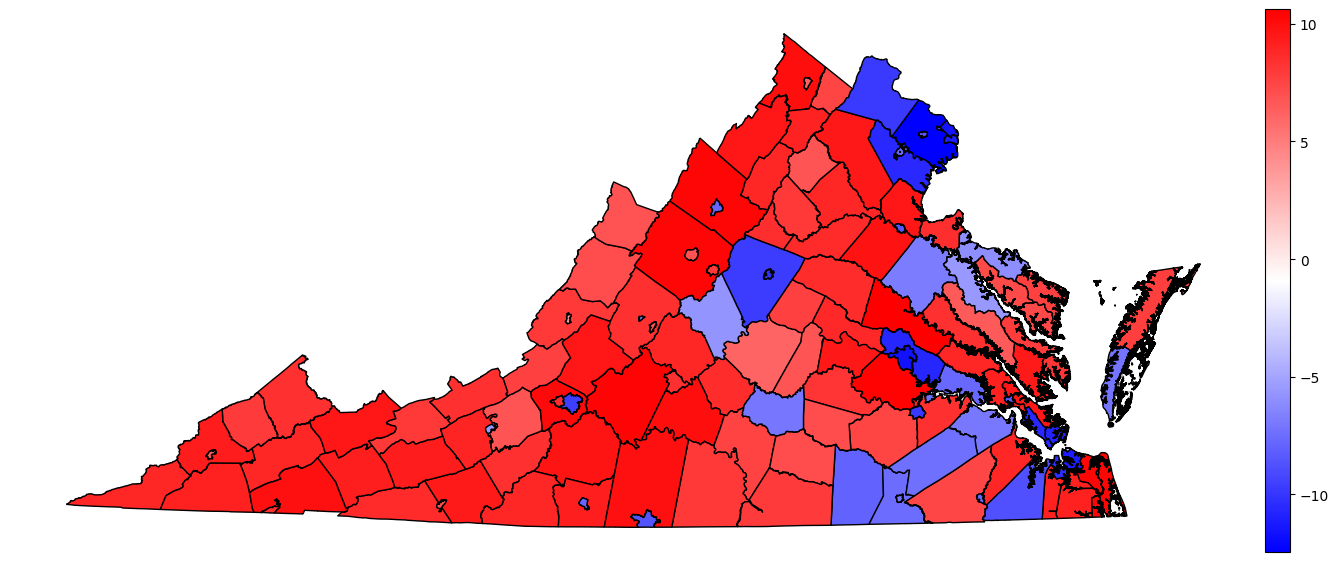

In [10]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='vote_diff_ihs',legend=True,cax=cax,cmap='bwr',edgecolor='k')